# Replay setup

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np

from aux import sgmd
from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from replay import plot, smln

P = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 1000,
    'W_PC_PC': 0.03, 'L_PC_PC': 0.083, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .15,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.009, 'E_L_INH': -0.058, 'V_TH_INH': -0.036, 'V_R_INH': -0.058, 'T_R_INH': 0.002,  # unused (presently)
    
    # Inh. architecture
    'N_INH': 100,
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.005, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 125, 
    
    # potentiation
    'SGM_MAX': 2, 'B_SGM': 1, 'R_SGM': 10
}

S_PARAMS = {
    "RNG_SEED": 0,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    'SPD': 0.2,
    
    'TRG': [
        {'T': 0.75, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
        {'T': 1.25, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': -1, 'Y': 0.75},
        {'T': 1.75, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
        {'T': 2.25, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': -1, 'Y': 0.75},
    ],
    
    "schedule": {"D_SMLN": 3},
    
    "metrics": {
        "WDW": 0.1, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5,
    }
}

## Example sqexp place field

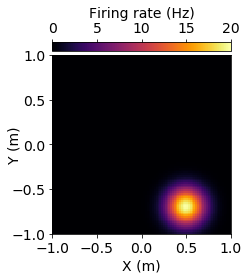

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

PF_X, PF_Y = (.5, -.7)
X_LIM = (-1, 1)
Y_LIM = (-1, 1)

fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)

x_ = np.linspace(*X_LIM, 100)
y_ = np.linspace(*Y_LIM, 100)

x, y = np.meshgrid(x_, y_)
dx = x - PF_X
dy = y - PF_Y
r = P['R_MAX'] * np.exp(-.5*(dx**2 + dy**2)/P['L_PL']**2)

im = ax.imshow(r, origin='lower', vmin=0, vmax=P['R_MAX'], cmap='inferno', extent=[-1, 1, -1, 1])

set_n_x_ticks(ax, 5)
set_n_y_ticks(ax, 5)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)', labelpad=-10)

set_font_size(ax, 14)

divider = make_axes_locatable(ax)
c_ax = divider.append_axes('top', '5%', pad=0.05)
c_ax.yaxis.set_visible(False)

cb = fig.colorbar(im, cax=c_ax, ticks=np.linspace(0, P['R_MAX'], 5), orientation='horizontal')

c_ax.set_xlabel('Firing rate (Hz)')
c_ax.xaxis.tick_top()
c_ax.xaxis.set_label_position('top')

set_font_size(c_ax, 14)

## Show firing rate and $\sigma$ vs dist from place field

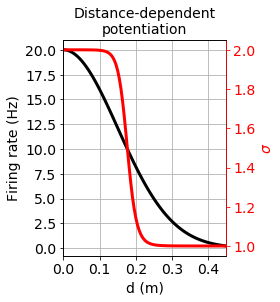

In [3]:
d = np.linspace(0, 3*P['L_PL'], 100)
r = P['R_MAX'] * np.exp(-.5*(d**2)/P['L_PL']**2)
sgm = 1 + (P['SGM_MAX'] - 1) * sgmd(P['B_SGM']*(r - P['R_SGM']))

fig, ax = plt.subplots(1, 1, figsize=(4, 4.3), tight_layout=True)
ax.plot(d, r, color='k', lw=3)

ax.set_xlabel('d (m)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('Distance-dependent\npotentiation')

ax_twin = ax.twinx()
ax_twin.plot(d, sgm, color='r', lw=3)
ax_twin.spines['right'].set_color('r')
ax_twin.tick_params(axis='y', colors='r')

ax.set_xlim(d[0], d[-1])

ax_twin.set_ylabel('$\sigma$', color='r')

set_font_size(ax, 14)
set_font_size(ax_twin, 14)

ax.grid()

## Recurrent connectivity profile

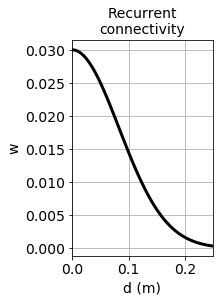

In [4]:
d = np.linspace(0, 3*P['L_PC_PC'], 100)
w = P['W_PC_PC']*np.exp(-.5*(d**2)/(P['L_PC_PC']**2))

fig, ax = plt.subplots(1, 1, figsize=(3.2, 4.3), tight_layout=True)

ax.plot(d, w, color='k', lw=3)

ax.set_xlim(d[0], d[-1])
ax.set_xlabel('d (m)')
ax.set_ylabel('w')
ax.set_title('Recurrent\nconnectivity')

ax.grid()

set_font_size(ax, 14)

# Replay demonstration

Running smln...
Smln complete.


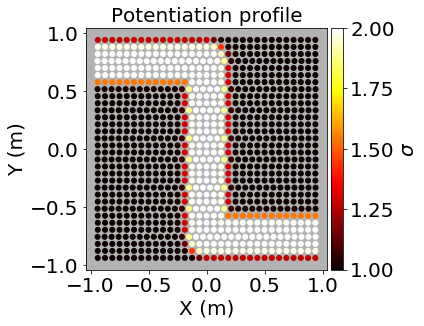

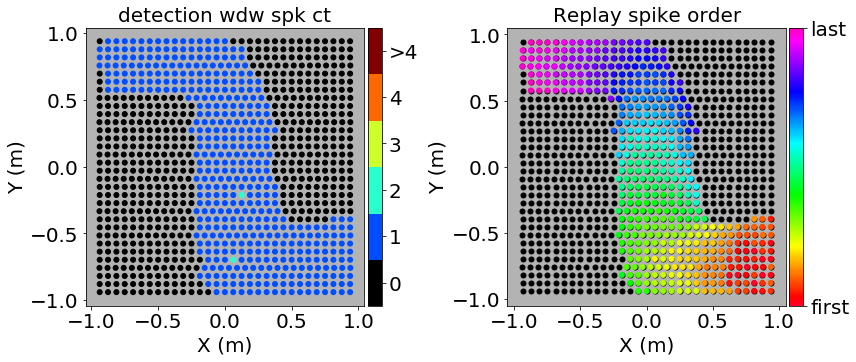

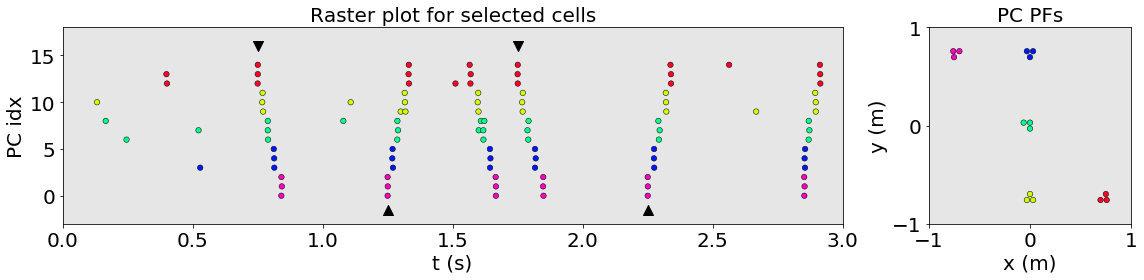

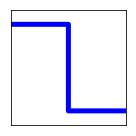

In [10]:
s_params = copy(S_PARAMS)
s_params['RNG_SEED'] = 14  # pick demo showing example spontaneous replay
s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]

print('Running smln...')
rslt = smln.run(P, s_params)
print('Smln complete.')

# make plots
plot.heat_maps(rslt, cmap='gist_rainbow');

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    ],
    colors=np.linspace(1, 0, 5),
    cmap='gist_rainbow',
    nearest=3,
    epoch='replay',
    trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
    y_lim=(-3, 18),
    y_ticks=np.linspace(0, 15, 4),
)

# plot trj
trj = smln.build_trj(s_params)
fig, ax = plt.subplots(1, 1, figsize=(2, 2), tight_layout=True)
ax.plot(trj['x'], trj['y'], lw=5, color='b')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.set_aspect('equal')

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

set_font_size(ax, 20);

Running smln...
Smln complete.


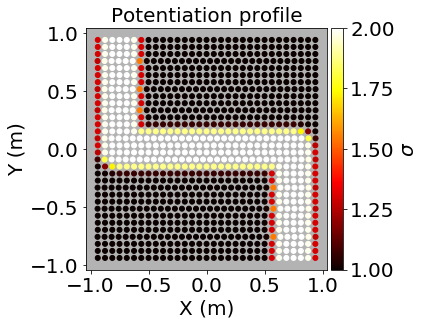

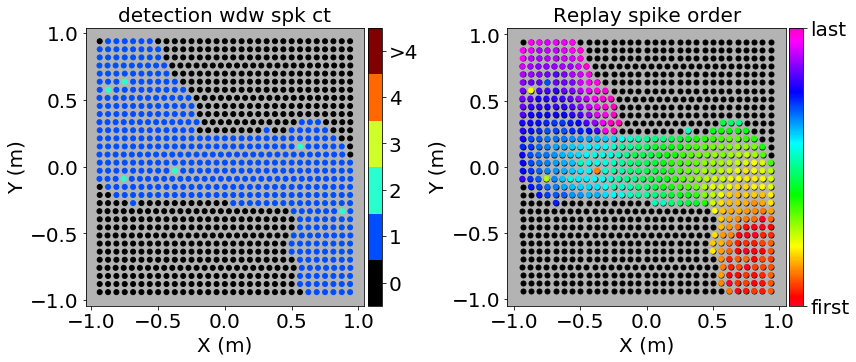

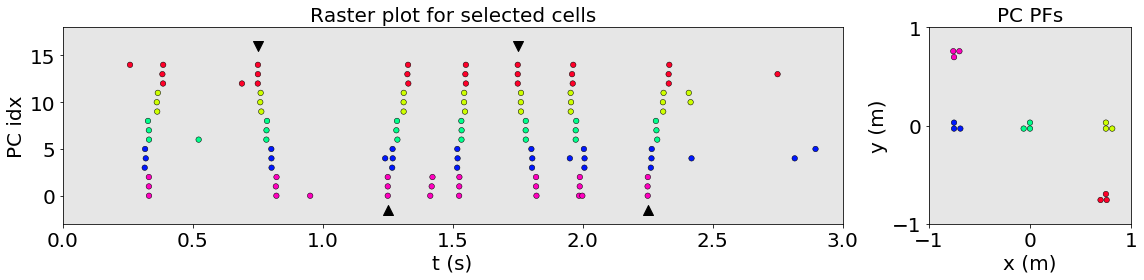

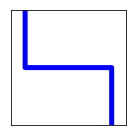

In [6]:
s_params = copy(S_PARAMS)
s_params['RNG_SEED'] = 2
s_params['TRJ'] = [(-.75, 1), (-.75, 0), (.75, 0), (.75, -1)]

print('Running smln...')
rslt = smln.run(P, s_params)
print('Smln complete.')

# make plots
plot.heat_maps(rslt, cmap='gist_rainbow');

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (-.75, 0), (0, 0), (.75, 0), (.75, -.75),  # trj
    ],
    colors=np.linspace(1, 0, 5),
    cmap='gist_rainbow',
    nearest=3,
    epoch='replay',
    trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
    y_lim=(-3, 18),
    y_ticks=np.linspace(0, 15, 4),
)

# plot trj
trj = smln.build_trj(s_params)
fig, ax = plt.subplots(1, 1, figsize=(2, 2), tight_layout=True)
ax.plot(trj['x'], trj['y'], lw=5, color='b')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.set_aspect('equal')

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

set_font_size(ax, 20);